In [1]:
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine
from langchain_core.tools import tool
import os

In [2]:
project=os.getenv('GOOGLE_PROJECT')
dataset=os.getenv('BIGQUERY_DATASET')
service_account_file='../credentials.json'
sql_url = (
    f"bigquery://{project}/{dataset}?credentials_path={service_account_file}"
)
db=SQLDatabase.from_uri(sql_url)

c:\Users\sunit\OneDrive\Desktop\MyProjects\LLM_Projects\DataVisualizationChatbot\venv\lib\site-packages\google\cloud\bigquery\client.py:589: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


In [3]:
#To run a query in the db
#db.run("select * from t_shirts where brand='nike' and color='Blue';")
db.run(f"SELECT * FROM {project}.{dataset}.t_shirts  WHERE brand = 'Nike' AND color = 'Blue'")


"[(4, 'Nike', 'Blue', 'L', 37, 14), (18, 'Nike', 'Blue', 'XS', 32, 46), (28, 'Nike', 'Blue', 'S', 14, 74), (48, 'Nike', 'Blue', 'M', 10, 34)]"

### Using Chains

In [4]:
from typing_extensions import TypedDict,Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [5]:
#Convert question to sql query
import os
from dotenv import load_dotenv

#os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')

# from langchain_groq import ChatGroq

# llm = ChatGroq(model="llama3-8b-8192")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

# from langchain_ollama import ChatOllama

# llm=ChatOllama(model='qwen2.5')




In [6]:
#pull a prompt from the Prompt Hub to instruct the model.
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

c:\Users\sunit\OneDrive\Desktop\MyProjects\LLM_Projects\DataVisualizationChatbot\venv\lib\site-packages\langsmith\client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


In [7]:
current_template=query_prompt_template.messages[0].prompt.template
current_template

'Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.\n\nNever query for all the columns from a specific table, only ask for a the few relevant columns given the question.\n\nPay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.\n\nOnly use the following tables:\n{table_info}\n\nQuestion: {input}'

In [8]:
# Modifying existing template to add specific instructions for a column
new_template = f"""
{current_template}

Additional Instructions:
- For getting count of t shirts always refer column 'stock_quantity' of 't_shirts' table. If multiple rows are returned calculate sum of column 'stock_quantity' for rows instead of counting the rows returned.
- For getting the price of t shirts always follow the following steps:
1. The 'price' column of 't_shirts' table indicates the base price of one t shirt only.
2. Next,Always check in the 'discounts' table if any entry exists for given t shirt id.
3. If entry exists 'pct_discount' column in that row refers to the discount percentage for a given t shirt id.
   Calculate discounted price as price*(1-(pct_discount/100)).Else ignore the 'discounts' table.

"""

In [9]:
# Create a new SystemMessagePromptTemplate with the updated template
from langchain.prompts import SystemMessagePromptTemplate

updated_message = SystemMessagePromptTemplate(
    prompt=query_prompt_template.messages[0].prompt.copy(update={"template": new_template})
)

# Replace the old message with the updated one
query_prompt_template.messages[0] = updated_message

C:\Users\sunit\AppData\Local\Temp\ipykernel_20012\1182658099.py:5: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  prompt=query_prompt_template.messages[0].prompt.copy(update={"template": new_template})


In [10]:
from typing_extensions import Annotated,Literal

#A TypedDict that specifies the expected structure of the output.
#query: A field of type str, annotated to indicate that it should contain a syntactically valid SQL query.
class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]

#generate an SQL query by interacting with an LLM and return it in a structured format
def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    #Configures the LLM to return its results as a QueryOutput structure, ensuring compliance with the expected format
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [11]:
query=write_query({"question": "How many blue nike t shirts are there?"})
query

{'query': "SELECT SUM(stock_quantity) AS total_stock\nFROM `t_shirts`\nWHERE color = 'Blue' AND brand = 'Nike'"}

In [12]:
#Execute Query
from langchain_community.tools import QuerySQLDataBaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDataBaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [13]:
execute_query(query)

C:\Users\sunit\AppData\Local\Temp\ipykernel_20012\1460524555.py:7: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  execute_query_tool = QuerySQLDataBaseTool(db=db)


{'result': '[(168,)]'}

In [14]:
#Generate answer
def generate_answer(state: State):
    """Answer question using retrieved information as context.
    Returns: The answer based on given query in plain english
    """
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [15]:
#Generate visualization
def get_visualization(state: State):
    """Returns recommended visualization or charts using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, recommend a visualization chart like bar chart,pie chart,scatter plot etc.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [16]:
def get_flow(state):
    """
    Determines whether to go to 'generate_answer' or 'get_visualization'
    based on the user query stored in the state.

    Args:
        state (dict): The current state containing the user query.

    Returns:
        str: The next node ('generate_answer' or 'get_visualization').
    """
    # Extract the user query from the state
    user_query = state.get("question", "")

    # Example condition: Check for keywords in the query
    visualization_keywords = ["chart", "graph", "visualize", "plot", "diagram"]

    # Check if the query contains visualization-related keywords
    if any(keyword in user_query.lower() for keyword in visualization_keywords):
        return "get_visualization"

    # Default flow
    return "generate_answer"


In [18]:
#Using langgraph for the same
from langgraph.graph import START, StateGraph,MessagesState,END

In [19]:

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query]
)
graph_builder.add_edge(START, "write_query")
graph_builder.add_conditional_edges(
    "execute_query",
    get_flow
)
graph_builder.add_node("generate_answer",generate_answer)
graph_builder.add_node("get_visualization",get_visualization)
graph_builder.add_edge("generate_answer", END)
graph_builder.add_edge("get_visualization", END)
graph = graph_builder.compile()

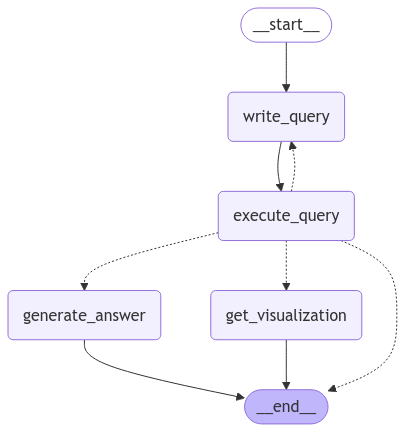

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
for step in graph.stream(
    {"question": "How many t-shirts do we have left for Nike in XS size and white color?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT SUM(stock_quantity) AS total_stock\nFROM `t_shirts`\nWHERE brand = 'Nike' AND size = 'XS' AND color = 'White'"}}
{'execute_query': {'result': '[(38,)]'}}
{'generate_answer': {'answer': 'You have 38 t-shirts left for Nike in XS size and white color.'}}


In [23]:
for step in graph.stream(
    {"question": "Which is the best plot or chart we can user for showing the distribution for Nike for different size and colors?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT t.brand, t.color, t.size, SUM(t.stock_quantity) AS total_stock_quantity, AVG(t.price * (1 - IFNULL(d.pct_discount / 100, 0))) AS avg_discounted_price\nFROM t_shirts t\nLEFT JOIN discounts d ON t.t_shirt_id = d.t_shirt_id\nWHERE t.brand = 'Nike'\nGROUP BY t.brand, t.color, t.size\nORDER BY total_stock_quantity DESC\nLIMIT 10;"}}
{'execute_query': {'result': "[('Nike', 'Black', 'XS', 100, 47.0), ('Nike', 'Red', 'XL', 100, 16.0), ('Nike', 'White', 'L', 78, 27.3), ('Nike', 'Blue', 'S', 74, 14.0), ('Nike', 'White', 'XL', 69, 13.0), ('Nike', 'Black', 'M', 66, 44.0), ('Nike', 'Black', 'S', 60, 37.0), ('Nike', 'Black', 'L', 60, 41.0), ('Nike', 'Red', 'M', 55, 45.0), ('Nike', 'Blue', 'XS', 46, 32.0)]"}}
{'get_visualization': {'answer': "To visualize the distribution of stock quantities for Nike t-shirts across different sizes and colors, a **bar chart** would be the most effective choice. \n\n### Reasons for Choosing a Bar Chart:\n1. **Comparison**: A bar chart

In [25]:
for step in graph.stream(
    {"question": "What is the total price of 4 extra small white Nike t-shirts?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT t_shirts.t_shirt_id, t_shirts.price * (1 - COALESCE(discounts.pct_discount / 100.0, 0)) AS discounted_price FROM t_shirts LEFT JOIN discounts ON t_shirts.t_shirt_id = discounts.t_shirt_id WHERE t_shirts.color = 'White' AND t_shirts.size = 'XS' AND t_shirts.brand = 'Nike' LIMIT 10"}}
{'execute_query': {'result': "[(68, Decimal('24.000000'))]"}}
{'generate_answer': {'answer': 'Based on the SQL query and result provided, we can determine that a single extra small (XS) white Nike t-shirt has a discounted price of $24.00.\n\nTo find the total price for 4 such t-shirts, simply multiply this price by 4:\n\n\\[ \\text{Total Price} = 24.00 \\times 4 = 96.00 \\]\n\nTherefore, the total price for 4 extra small white Nike t-shirts is $96.00.'}}


In [26]:
for step in graph.stream(
    {"question": "What is the price of 5 medium red Van Huesen t-shirts?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT t_shirts.price * (1 - IFNULL(discounts.pct_discount / 100, 0)) AS discounted_price FROM t_shirts JOIN discounts ON t_shirts.t_shirt_id = discounts.t_shirt_id WHERE t_shirts.brand = 'Van Huesen' AND t_shirts.color = 'Red' AND t_shirts.size = 'M' LIMIT 10;"}}
{'execute_query': {'result': "[(Decimal('20.000000'),)]"}}
{'generate_answer': {'answer': 'The price of a medium red Van Huesen t-shirt, after applying any discounts, is $20.00.'}}


In [143]:
for step in graph.stream(
    {"question": "How much is the total price of the inventory for all S-size t-shirts?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT SUM(CASE \n            WHEN d.pct_discount IS NOT NULL THEN t.price * (1 - (d.pct_discount / 100)) \n            ELSE t.price \n        END * t.stock_quantity) AS total_inventory_value\nFROM `t_shirts` t \nLEFT JOIN `discounts` d ON t.t_shirt_id = d.t_shirt_id \nWHERE t.size = 'S'"}}
{'execute_query': {'result': '[(18018.0,)]'}}
{'generate_answer': {'answer': 'The total price of the inventory for all S-size t-shirts is $18,018.00.'}}


In [144]:
for step in graph.stream(
    {"question": "If we have to sell all the Levi’s T-shirts today with discounts applied. How much revenue  our store will generate (post discounts)?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT SUM(CASE WHEN d.pct_discount IS NOT NULL THEN t.price * (1 - (d.pct_discount / 100)) ELSE t.price END * t.stock_quantity) AS total_revenue\nFROM `t_shirts` t\nLEFT JOIN `discounts` d ON t.t_shirt_id = d.t_shirt_id\nWHERE t.brand = 'Levi'\nLIMIT 10;"}}
{'execute_query': {'result': '[(14176.800000000001,)]'}}
{'generate_answer': {'answer': 'The revenue our store will generate from selling all the Levi’s T-shirts today, after applying discounts, is approximately **$14,176.80**.'}}


In [145]:
for step in graph.stream(
    {"question": "If we have to sell all the Levi’s T-shirts today. How much revenue our store will generate without discount?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT SUM(price * stock_quantity) AS total_revenue\nFROM t_shirts\nWHERE brand = 'Levi'"}}
{'execute_query': {'result': '[(14731,)]'}}
{'generate_answer': {'answer': "The total revenue our store will generate from selling all the Levi's T-shirts today, without any discount, is $14,731."}}


In [146]:
for step in graph.stream(
    {"question": "How many white color Levi's shirt I have?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT SUM(stock_quantity) AS total_stock\nFROM `t_shirts`\nWHERE brand = 'Levi' AND color = 'White'"}}
{'execute_query': {'result': '[(158,)]'}}
{'generate_answer': {'answer': "You have a total of 158 white color Levi's shirts."}}


### human-in-the-loop: we can interrupt our application before sensitive steps (such as the execution of a SQL query) for human review. This is enabled by LangGraph's persistence layer, which saves run progress to your storage of choice. Below, we specify storage in-memory:

In [20]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

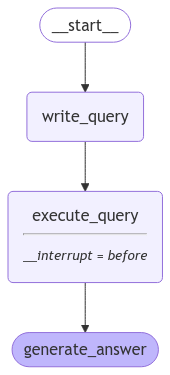

In [21]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
for step in graph.stream(
    {"question": "What is the price of 5 large blue Nike t shirts?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")


{'write_query': {'query': "SELECT t_shirts.brand, t_shirts.color, t_shirts.size, t_shirts.price, SUM(discounts.pct_discount) AS discount FROM t_shirts JOIN discounts ON t_shirts.t_shirt_id = discounts.t_shirt_id WHERE t_shirts.color = 'Blue' AND t_shirts.size = 'L' AND t_shirts.brand = 'Nike' GROUP BY t_shirts.brand, t_shirts.color, t_shirts.size, t_shirts.price LIMIT 10"}}
{'__interrupt__': ()}
{'execute_query': {'result': "[('Nike', 'Blue', 'L', 37, Decimal('5.00'))]"}}
{'generate_answer': {'answer': "The user question is: What is the price of 5 large blue Nike t shirts?\n\nThe SQL query provided is to get the price of large blue Nike t-shirts, but it doesn't specifically ask for the price of 5 of them. The result it provides is the price of one large blue Nike t-shirt with a 5% discount.\n\nTo find the price of 5 large blue Nike t-shirts, we need to multiply the price by 5. The price is $37 (without discount) and there is a 5% discount, so the price is:\n\n$37 - (5% of $37) = $37 - 